In [1]:
import tensorflow as tf
# current processing
tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'))

from importlib import import_module
import keras
from keras.api._v2 import keras as KerasAPI
keras: KerasAPI = import_module("tensorflow.keras")
print(tf.__version__)

from keras import layers
from keras.models import Sequential
from keras.layers import preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import time
import itertools
import shutil

from sklearn.metrics import confusion_matrix



2.10.0


In [2]:
path = ''
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/deepLearningAs3/'

random_state_global = 42

pathfinal = path + 'model_history/model_arch_I/'
pathfinal2 = path + 'model_images/'

epoch_val = 3000
batch_size_val = 32
threshold_val = 1e-4
learning_rate_val = 1e-3

Hidden_layer_I_N = 20
Hidden_layer_II_N = 15
Hidden_layer_III_N = 10
Output_layer_N = 5


Hidden_layer_Activation = "tanh"
Output_layer_Activation = "softmax"



IMG_SIZE = (224, 224)
checkpoint_path = ''
train_dir = 'Group_20/train'
test_dir = 'Group_20/test'
val_dir = 'Group_20/val'

In [3]:
def delete_folder_contents(path_erase):
    '''
    take path to erase all data present on it
    '''
    folder_name = path_erase
    # Get all files in the folder
    files = os.listdir(folder_name)

    # Loop through the files and delete them
    for file in files:
        file_path = os.path.join(folder_name, file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")
            
delete_folder_contents(pathfinal)

### Preparing Data

In [4]:
# unzip_data('Group_20.zip')

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir('Group_20')

There are 3 directories and 1 images in 'Group_20'.
There are 5 directories and 0 images in 'Group_20/test'.
There are 0 directories and 20 images in 'Group_20/test/butterfly'.
There are 0 directories and 20 images in 'Group_20/test/helicopter'.
There are 0 directories and 20 images in 'Group_20/test/ketch'.
There are 0 directories and 20 images in 'Group_20/test/brain'.
There are 0 directories and 20 images in 'Group_20/test/ewer'.
There are 5 directories and 0 images in 'Group_20/train'.
There are 0 directories and 50 images in 'Group_20/train/butterfly'.
There are 0 directories and 50 images in 'Group_20/train/helicopter'.
There are 0 directories and 50 images in 'Group_20/train/ketch'.
There are 0 directories and 50 images in 'Group_20/train/brain'.
There are 0 directories and 50 images in 'Group_20/train/ewer'.
There are 5 directories and 0 images in 'Group_20/val'.
There are 0 directories and 10 images in 'Group_20/val/butterfly'.
There are 0 directories and 10 images in 'Group_2

In [5]:
# Setup data inputs
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = keras.utils.image_dataset_from_directory(train_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE,
                                                        seed=random_state_global,
                                                        batch_size = batch_size_val,
                                                        shuffle=True)
train_data = train_ds.map(lambda x, y: (normalization_layer(x), y))


test_ds = keras.utils.image_dataset_from_directory(test_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE,
                                                        seed=random_state_global,
                                                        batch_size = batch_size_val,
                                                        shuffle=False) # don't shuffle test data for prediction analysis
test_data = test_ds.map(lambda x, y: (normalization_layer(x), y))


valid_ds = keras.utils.image_dataset_from_directory(val_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE,
                                                        seed=random_state_global,
                                                        batch_size = batch_size_val,
                                                        shuffle=False) # don't shuffle valid data for prediction analysis
valid_data = valid_ds.map(lambda x, y: (normalization_layer(x), y))

class_names = train_ds.class_names
print(f'\nclass names are {class_names}')

Found 250 files belonging to 5 classes.
Found 100 files belonging to 5 classes.
Found 50 files belonging to 5 classes.

class names are ['brain', 'butterfly', 'ewer', 'helicopter', 'ketch']


2023-04-24 02:58:22.669997: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


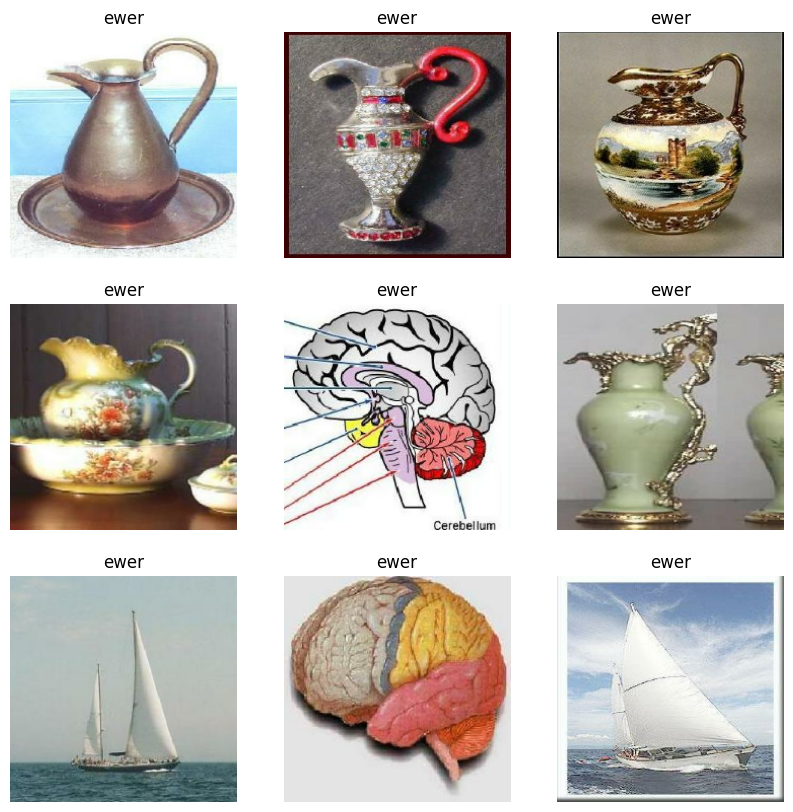

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels)])
    plt.axis("off")

In [10]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

### Callbacks

In [7]:
class ModelSaving(keras.callbacks.Callback):
    def __init__(self):
        self.currentEpoch = 0
        
    def on_epoch_end(self, epoch, logs=None):
        self.currentEpoch = epoch

    def on_train_end(self, logs=None):
        self.model.save(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.tf')
        # print("Training has ended!, model saved")

    
class HistorySaver(keras.callbacks.Callback):
    def __init__(self, initial_history):
        super(HistorySaver, self).__init__()
        self.history = {}
        self.currentEpoch = 0
        
        for key, value in [('loss', initial_history[0]), ('accuracy', initial_history[1]), ('val_loss', initial_history[2]), ('val_accuracy', initial_history[3])]:
            self.history.setdefault(key, []).append(value)
        
        # logs.items() = dict_items([('loss', 1.3612865209579468), ('accuracy', 0.46034255623817444), ('val_loss', 1.1157031059265137), ('val_accuracy', 0.6484848856925964)])
    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)
        self.currentEpoch = epoch
        
    def on_train_end(self, logs=None):
        pd.DataFrame(self.history).to_csv(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.csv', index=False)
        # print("Training has ended!, model history saved")



# create the callbacks

model_saver = ModelSaving()

# This means if for 5 epochs the accuracy has no progress on 
# the validation set then it would stop and store the previous best value.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss',
                                                  patience=1,
                                                  min_delta=threshold_val,
                                                  mode='min',
                                                  restore_best_weights=False, 
                                                  verbose=0)

checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         save_freq="epoch") # save the model weights which score the best validation accuracy) 

In [8]:
initializer_1 = tf.keras.initializers.GlorotUniform(seed=random_state_global)
initializer_2 = tf.keras.initializers.GlorotUniform(seed=random_state_global+1)
initializer_3 = tf.keras.initializers.GlorotUniform(seed=random_state_global+2)
initializer_4 = tf.keras.initializers.GlorotUniform(seed=random_state_global+3)

### Architecture-1 (4-layer  architecture)

In [9]:
tf.random.set_global_generator(tf.random.Generator.from_seed(random_state_global))
tf.random.set_seed(random_state_global)
model_1 = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  keras.layers.Conv2D(filters=8, kernel_size=11, strides=4, activation="relu", kernel_initializer=initializer_1),
  keras.layers.MaxPool2D(pool_size=3, strides=2),
  keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, activation="relu", kernel_initializer=initializer_2),
  keras.layers.MaxPool2D(pool_size=3, strides=2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation="relu", kernel_initializer=initializer_3),
  keras.layers.Dense(5, activation="softmax", kernel_initializer=initializer_4) # binary activation output
], name="model_1")

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                    optimizer=keras.optimizers.Adam(),
                    metrics=["accuracy"])

  # Evaluate the model initial losses
initial_train_loss, initial_train_acc = model_1.evaluate(train_data, verbose=0)
initial_valid_loss, initial_valid_acc = model_1.evaluate(valid_data, verbose=0)

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=epoch_val,
                        validation_data=valid_data,
                        batch_size=32,
                        callbacks=[model_saver, HistorySaver((initial_train_loss, initial_train_acc, initial_valid_loss, initial_valid_acc)), early_stopping_cb],
                        verbose=1)

Epoch 1/3000
8/8 [==============================] - 1s 44ms/step - loss: 1.5595 - accuracy: 0.2760 - val_loss: 1.4097 - val_accuracy: 0.5800
Epoch 2/3000
8/8 [==============================] - 0s 46ms/step - loss: 1.2676 - accuracy: 0.5960 - val_loss: 1.1679 - val_accuracy: 0.5600
Epoch 3/3000
8/8 [==============================] - 0s 47ms/step - loss: 1.1837 - accuracy: 0.5560 - val_loss: 0.9584 - val_accuracy: 0.6400
Epoch 4/3000
8/8 [==============================] - 1s 61ms/step - loss: 0.8954 - accuracy: 0.6640 - val_loss: 0.7442 - val_accuracy: 0.8000
Epoch 5/3000
8/8 [==============================] - 0s 46ms/step - loss: 0.7056 - accuracy: 0.7640 - val_loss: 0.7113 - val_accuracy: 0.7400
Epoch 6/3000
8/8 [==============================] - 0s 50ms/step - loss: 0.5993 - accuracy: 0.7840 - val_loss: 0.7078 - val_accuracy: 0.7600
Epoch 7/3000
8/8 [==============================] - 0s 44ms/step - loss: 0.5184 - accuracy: 0.8400 - val_loss: 0.8768 - val_accuracy: 0.6600
Epoch 8/3000


INFO:tensorflow:Assets written to: model_history/model_arch_I/model_1_38.tf/assets


INFO:tensorflow:Assets written to: model_history/model_arch_I/model_1_38.tf/assets


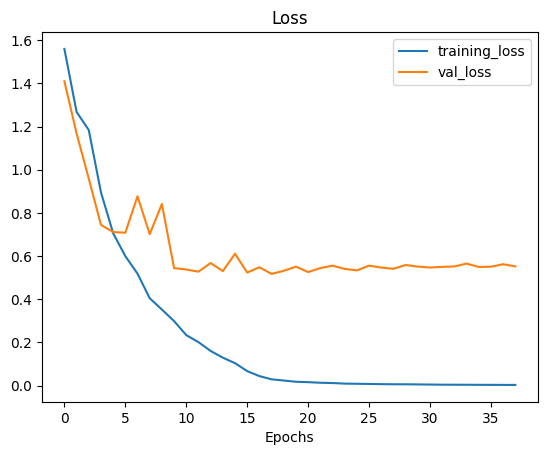

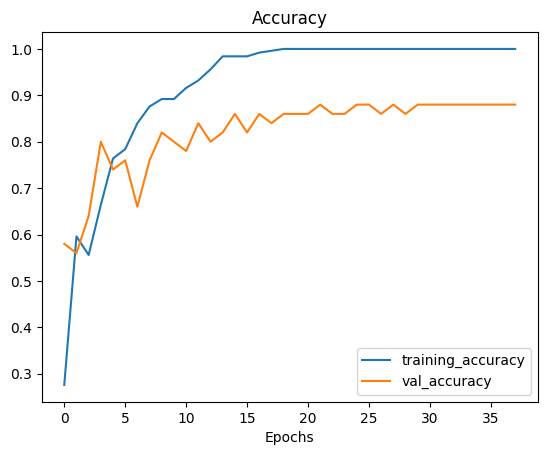

In [11]:
plot_loss_curves(history_1)